In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
project_path = '/content/drive/MyDrive/Project/'
data_path = '/content/drive/MyDrive/Project/trainingSet.csv'

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sortedcontainers import SortedList, SortedSet, SortedDict



**1. Reading Dataset**



In [8]:
df = pd.read_csv(data_path)
df.drop('Genre2',axis='columns', inplace=True)
df.drop('Genre3',axis='columns', inplace=True)



**2. Dataset Analysis**



In [9]:
df

,imdbID,Title,Plot,Genre1
0,tt0114709,Toy Story,A little boy named Andy loves to be in his roo...,Animation
1,tt0113497,Jumanji,After being trapped in a jungle board game for...,Action
2,tt0113228,Grumpier Old Men,Things don't seem to change much in Wabasha Co...,Comedy
3,tt0114885,Waiting to Exhale,This story based on the best selling novel by ...,Comedy
4,tt0113041,Father of the Bride Part II,"In this sequel to ""Father of the Bride"", Georg...",Comedy
...,...,...,...,...
4451,tt0790770,Miles Ahead,An exploration of the life and music of Miles ...,Biography
4452,tt0165473,Demons,"After being robbed by a geisha, a ronin warrio...",Drama
4453,tt0155350,The Video Dead,An unlabelled crate from an unknown source is ...,Comedy
4454,tt0918940,The Legend of Tarzan,John Clayton following his parents' death in A...,Action


In [10]:
distinct_genres = SortedSet() #ordered set of distict element
for i in range(1, 2):
  column = "Genre" + str(i)
  for x in df[column]:
    gnr = str(x)
    gnr = gnr.lower()
    gnr = gnr.strip()
    gnr = gnr.strip(' ')
    if (str(gnr) != "nan"):
      distinct_genres.add(gnr)
#print('In this dataset there are', len(distinct_genres), 'distinct genres')
all_genres = list(distinct_genres)

**In this dataset there are 19 distinct genres** <br> <br>


1.Animation<br> 
2.Action<br>
3.Comedy<br>
4.Adventure<br>
5.Biography<br>
6.Drama<br>
7.Crime<br>
8.Fantasy<br>
9.Mystery<br>
10.Romance<br>
11.Sci-Fi<br>
12.Documentary<br>
13.Family<br>
14.Horror<br>
15.Thriller<br>
16.Short<br>
17.Western<br>
18.War<br>
19.Musical<br>



In [11]:
all_genres_count = {}       # counting every genres
for i in range(1, 2):
  column = "Genre" + str(i)
  for x in df[column]:
    gnr = str(x)
    gnr = gnr.lower()
    gnr = gnr.strip()
    gnr = gnr.strip(' ')
    if (str(gnr) != "nan"):
      if (all_genres_count.get(gnr) == None):
        all_genres_count[gnr] = 1
      else :
        all_genres_count[gnr] += 1
#print('In this dataset there are', len(distinct_genres), 'distinct genres')

In [12]:
plot_column_name = []
plot_height = []
for name, cnt in all_genres_count.items():
  plot_column_name.append(name)
  plot_height.append(cnt)

No handles with labels found to put in legend.


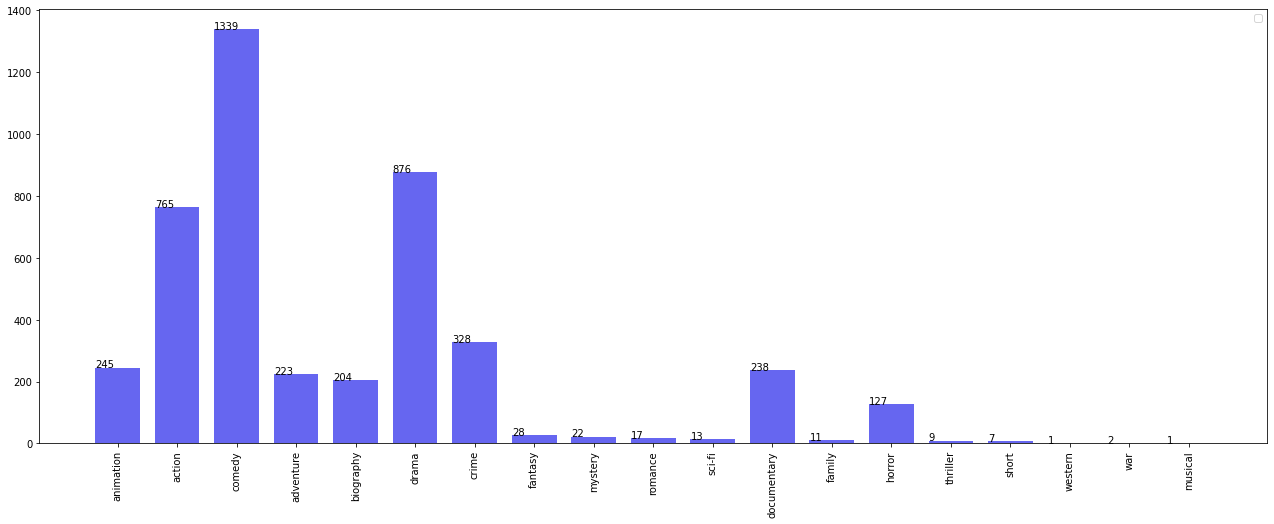

In [13]:
x = np.arange(len(plot_height))
width = .75
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(22)
rects1 = ax.bar(x, plot_height, width, color=(0.0, 0.0, 0.9, 0.6))
for i, v in enumerate(plot_height):
    plt.text(x[i] - width / 2, v, str(v))
plt.xticks(x, plot_column_name, rotation='vertical')
plt.legend()

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import os
from os import path
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import threading
import random

In [15]:
class Custom_Count_Vectorizer:
  """instance"""
  my_vectorizer = None
  word_vector = None
  dataset = None

  """methods"""
  #@ initalize the vocabulary based on the given corpus and make a dataset with given labels
  def __init__(self, corpus, corpus_label, vectorizer = 'COUNT-B'):
    #@initialize the vectorizer
    if (vectorizer == 'COUNT-B'):
      self.my_vectorizer = CountVectorizer(stop_words='english', binary=True)
      print('Using Binary Count Vectorizer')
    elif (vectorizer == 'COUNT'):
      self.my_vectorizer = CountVectorizer(stop_words='english')
      print('Using Count Vectorizer')
    elif (vectorizer == 'TF-IDF'):
      self.my_vectorizer = TfidfVectorizer(stop_words='english')
      print('Using TF-IDF Vectorizer')
    else:
      self.my_vectorizer = CountVectorizer(stop_words='english', binary=True)
      print('Can not use the specific vectorizer.\nUsing Binary Count Vectorizer as Default')

    self.word_vector = self.my_vectorizer.fit_transform(corpus).toarray()
    assert(len(self.word_vector) == len(corpus_label))
    self.dataset = []
    for i in range(len(self.word_vector)):
      self.dataset.append((torch.FloatTensor(self.word_vector[i]) / corpus_label[i][1], corpus_label[i][0]))

  #@ returns a word vector for a new text, based on the vocabulary
  def get_vector(self, ar):
    return self.my_vectorizer.transform([ar]).toarray()[0]
  
  #@ retruns a word vector for a new text, based on the vocabulary in a tensor form
  def get_tensor(self, ar):
    return torch.FloatTensor(self.my_vectorizer.transform([ar]).toarray()[0])

  #@ returns a dataset with labels, based on the corpus that was given during class initialization
  def get_dataset(self, shuffle = False):
    if (shuffle):
      random.shuffle(self.dataset)
    return self.dataset

In [16]:
label_to_int = {}
int_to_label = {}
given_label = 0
for name in all_genres_count.keys():
  label_to_int[name] = given_label
  int_to_label[given_label] = name
  given_label += 1

In [17]:
corpus = []
corpus_label = []
def make_corpus():
  for i in range(len(df['Plot'])):
    sen = str(df['Plot'][i])
    sen = sen.strip()
    sen = sen.strip(' ')
    for j in range(1, 2):
      gg = str('Genre') + str(j)
      gnr = str(df[gg][i])
      gnr = gnr.lower()
      gnr = gnr.strip()
      gnr = gnr.strip(' ')
      if (gnr != "nan"):
        corpus.append(sen)
        ival = label_to_int[gnr]
        assert(ival >= 0 and ival < 22)
        corpus_label.append((ival, j * j))
make_corpus()

**TF-IDF + Deep Neural Network**

In [34]:
custom_count_vectorizer = Custom_Count_Vectorizer(corpus=corpus, corpus_label=corpus_label, vectorizer='TF-IDF')
dataset = custom_count_vectorizer.get_dataset(shuffle = True)

Using TF-IDF Vectorizer


In [35]:
train_cnt = int(80.0 * len(dataset) / 100.0)
train_dataset = dataset[ : train_cnt]
test_dataset = dataset[train_cnt : ]
print('Train size =', len(train_dataset), '\nTest size =', len(test_dataset))

Train size = 3564 
Test size = 892


In [42]:
# Hyperparameters
batch_size =180 
num_iters =9000 
input_dim = len(dataset[0][0])
output_dim = len(all_genres)
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  
print(num_epochs)

454


In [44]:
class DeepNeuralNetworkModel(nn.Module):
  def __init__(self, input_size, num_classes, num_hidden_1, num_hidden_2, num_hidden_3):
    super().__init__()
    ### 1st hidden layer: 784 --> 100
    self.linear_1 = nn.Linear(input_size, num_hidden_1)
    ### Non-linearity in 1st hidden layer
    self.relu_1 = nn.ReLU6()

    ### 2nd hidden layer: 100 --> 100
    self.linear_2 = nn.Linear(num_hidden_1, num_hidden_2)
    ### Non-linearity in 2nd hidden layer
    self.relu_2 = nn.ReLU6()

    self.linear_3 = nn.Linear(num_hidden_2, num_hidden_3)
    ### Non-linearity in 2nd hidden layer
    self.relu_3 = nn.ReLU6()

    ### Output layer: 100 --> 10
    self.linear_out = nn.Linear(num_hidden_3, num_classes)

  def forward(self, x):
    ### 1st hidden layer
    out  = self.linear_1(x)
    ### Non-linearity in 1st hidden layer
    out = self.relu_1(out)
    
    ### 2nd hidden layer
    out  = self.linear_2(out)
    ### Non-linearity in 2nd hidden layer
    out = self.relu_2(out)
    
    ### 2nd hidden layer
    out  = self.linear_3(out)
    ### Non-linearity in 2nd hidden layer
    out = self.relu_3(out)

    # Linear layer (output)
    probas  = self.linear_out(out)
    return probas

In [45]:
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden_1 = 550, num_hidden_2 = 250, num_hidden_3 = 80)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=25769, out_features=550, bias=True)
  (relu_1): ReLU6()
  (linear_2): Linear(in_features=550, out_features=250, bias=True)
  (relu_2): ReLU6()
  (linear_3): Linear(in_features=250, out_features=80, bias=True)
  (relu_3): ReLU6()
  (linear_out): Linear(in_features=80, out_features=19, bias=True)
)

In [46]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [47]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
  for i, (plots, labels) in enumerate(train_loader):

    plots = plots.view(-1, input_dim).to(device)
    labels = labels.to(device)

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    # Forward pass to get output/logits
    outputs = model(plots) 
    
    # Calculate Loss: softmax --> cross entropy loss
    loss = criterion(outputs, labels)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

    iter += 1

    if iter % 500 == 0:
      # Calculate Accuracy         
      correct = 0
      total = 0
      # Iterate through test dataset
      for plots, labels in test_loader:
               
        plots = plots.view(-1, input_dim).to(device)

        # Forward pass only to get logits/output
        outputs = model(plots)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs, 1)

        # Total number of labels
        total += labels.size(0)


        # Total correct predictions
        if torch.cuda.is_available():
          correct += (predicted.cpu() == labels.cpu()).sum() 
          #print('cuda', predicted)
        else:
          correct += (predicted == labels).sum()
          #print('normal', predicted)

      accuracy = 100 * correct.item() / total
      # Print Loss
      iteration_loss.append(loss.item())
      print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.00215915497392416. Accuracy: 40.02242152466368
Iteration: 1000. Loss: 0.00024781428510323167. Accuracy: 39.573991031390136
Iteration: 1500. Loss: 8.431248716078699e-05. Accuracy: 39.91031390134529
Iteration: 2000. Loss: 4.4604381400858983e-05. Accuracy: 40.35874439461883
Iteration: 2500. Loss: 3.88813678000588e-05. Accuracy: 40.134529147982065
Iteration: 3000. Loss: 2.072214920190163e-05. Accuracy: 40.69506726457399
Iteration: 3500. Loss: 1.989482007047627e-05. Accuracy: 40.69506726457399
Iteration: 4000. Loss: 1.7899455997394398e-05. Accuracy: 40.47085201793722
Iteration: 4500. Loss: 8.562782568333205e-06. Accuracy: 40.47085201793722
Iteration: 5000. Loss: 9.375416084367316e-06. Accuracy: 40.91928251121076
Iteration: 5500. Loss: 4.170618922216818e-06. Accuracy: 41.03139013452915
Iteration: 6000. Loss: 3.4835263704735553e-06. Accuracy: 40.91928251121076
Iteration: 6500. Loss: 2.534839268264477e-06. Accuracy: 40.80717488789238
Iteration: 7000. Loss: 2.51080882662

In [48]:
#settings 
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), project_path + 'TF_IDF_DEEP_NN_model_final.pkl') 

[0.00215915497392416, 0.00024781428510323167, 8.431248716078699e-05, 4.4604381400858983e-05, 3.88813678000588e-05, 2.072214920190163e-05, 1.989482007047627e-05, 1.7899455997394398e-05, 8.562782568333205e-06, 9.375416084367316e-06, 4.170618922216818e-06, 3.4835263704735553e-06, 2.534839268264477e-06, 2.5108088266279083e-06, 1.9661076748889172e-06, 1.538949391033384e-06, 1.5190721569524612e-06, 7.914148341114924e-07]


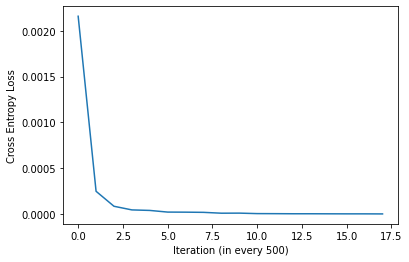

In [49]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [50]:
def new_prediction(plot):
  plot = custom_count_vectorizer.get_tensor(text)
  plot = plot.view(-1, input_dim).to(device)
  outputs = model(plot)
  _, predicted = torch.max(outputs, 1)
  return int(predicted)
  
def new_prediction_by_vector(vector):
  plot = vector
  plot = plot.view(-1, input_dim).to(device)
  outputs = model(plot)
  _, predicted = torch.max(outputs, 1)
  return int(predicted)

In [51]:
plot = "John McBut when a bomb goes off in the Bonwit Teller Department Store the police go insane trying to figure out what's going on. Soon, a man named Simon calls and asks for McClane. Simon tells Inspector Walter Cobb that McClane is going to play a game called \"Simon Says\". He says that McClane is going to do the tasks he assigns him. If not, he'll set off another bomb. With the help of a Harlem electrician, John McClane must race all over New York trying to figure out the frustrating puzzles that the crafty terrorist gives him. But when a bomb goes off in a subway station right by the Federal Reserve things start to get heated."
prediction=new_prediction(plot)
print(prediction,int_to_label[prediction])

1 action


In [52]:
out_true = []
out_pred = []
for plot in test_dataset:
  pred = new_prediction_by_vector(plot[0])
  out_true.append(plot[1])
  out_pred.append(pred)

cm = confusion_matrix(out_true, out_pred)
print(cm)
cr = classification_report(out_true, out_pred)
print(cr)

[[  7  23   1   8   0   7   7   0   0   0   0   0   0   0   0   0]
 [  7 120  10  10   1  14  20   0   0   0   0   0   0   0   0   0]
 [  2  48 117   4   2  69   8   0   0   1   0   1   0   0   0   0]
 [  0  16   4   7   1   5   7   0   0   0   0   0   0   0   0   0]
 [  0   4   5   2   2  26   3   0   0   0   0   1   0   0   0   0]
 [  0  24  29   1   2  84  17   0   0   0   0   2   0   0   0   0]
 [  0  19  12   0   0  18  13   0   0   0   0   0   0   0   0   0]
 [  0   3   0   1   0   2   2   0   0   0   0   0   0   1   0   0]
 [  0   1   0   0   0   2   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  1   1   0   0   0   1   1   0   0   0   0   0   0   0   0   0]
 [  0   2   3   1   4  36   5   0   0   2   0   6   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   4   2   0   0   4   6   0   0   0   0   0   0   3   0   0]
 [  0   1   1   0   0   0   1   0   0   0   0   0   0   0   0 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**TF-IDF + Logistic Regression**

In [53]:
custom_count_vectorizer = Custom_Count_Vectorizer(corpus=corpus, corpus_label=corpus_label, vectorizer='TF-IDF')
dataset = custom_count_vectorizer.get_dataset(shuffle=True)

Using TF-IDF Vectorizer


In [54]:
train_cnt = int(80.0 * len(dataset) / 100.0)
train_dataset = dataset[ : train_cnt]
test_dataset = dataset[train_cnt : ]
print('Train size =', len(train_dataset), '\nTest size =', len(test_dataset))

Train size = 3564 
Test size = 892


In [55]:
# Hyperparameters
batch_size = 180
num_iters = 9000
input_dim = len(dataset[0][0])
output_dim = len(all_genres)
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [56]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  
print(num_epochs)

454


In [57]:
class LogisticRegressionModel(nn.Module):
  def __init__(self, input_size, num_classes):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, x):
    logits  = self.linear(x)
    probas = F.softmax(logits, dim=1)
    return logits, probas

In [58]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=25769, out_features=19, bias=True)
)

In [59]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [60]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
  for i, (plots, labels) in enumerate(train_loader):

    plots = plots.view(-1, input_dim).to(device)
    labels = labels.to(device)

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    # Forward pass to get output/logits
    logits, probas = model(plots) 

    # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
    loss = F.cross_entropy(logits, labels)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

    iter += 1

    if iter % 1000 == 0:
      # Calculate Accuracy         
      correct = 0
      total = 0
      # Iterate through test dataset
      for plots, labels in test_loader:
               
        plots = plots.view(-1, input_dim).to(device)

        # Forward pass only to get logits/output
        logits, probas = model(plots)

        # Get predictions from the maximum value
        _, predicted = torch.max(probas, 1)

        # Total number of labels
        total += labels.size(0)


        # Total correct predictions
        if torch.cuda.is_available():
          correct += (predicted.cpu() == labels.cpu()).sum() 
        else:
          correct += (predicted == labels).sum()

      accuracy = 100 * correct.item() / total

      # Print Loss
      iteration_loss.append(loss.item())
      print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print("done training")

Iteration: 1000. Loss: 0.9626441597938538. Accuracy: 43.60986547085202
Iteration: 2000. Loss: 0.4956914484500885. Accuracy: 45.964125560538115
Iteration: 3000. Loss: 0.26640230417251587. Accuracy: 46.74887892376682
Iteration: 4000. Loss: 0.14403869211673737. Accuracy: 46.63677130044843
Iteration: 5000. Loss: 0.08393736928701401. Accuracy: 47.08520179372197
Iteration: 6000. Loss: 0.05286024510860443. Accuracy: 47.53363228699551
Iteration: 7000. Loss: 0.031830012798309326. Accuracy: 47.19730941704036
Iteration: 8000. Loss: 0.023095805197954178. Accuracy: 46.860986547085204
Iteration: 9000. Loss: 0.01427452266216278. Accuracy: 47.08520179372197
done training


In [61]:
#settings 
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), project_path + 'TF_IDF_logistic_regression_final.pkl') 

[0.9626441597938538, 0.4956914484500885, 0.26640230417251587, 0.14403869211673737, 0.08393736928701401, 0.05286024510860443, 0.031830012798309326, 0.023095805197954178, 0.01427452266216278]


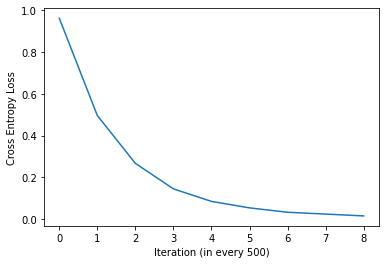

In [62]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [63]:
def new_prediction_lg(plot):
  plot = custom_count_vectorizer.get_tensor(text)
  plots = plot.view(-1, input_dim).to(device)
  logits, probas = model(plots)
  _, predicted = torch.max(probas, 1)
  return int(predicted)
  
def new_prediction_by_vector_lg(vector):
  plot = vector
  plot = plot.view(-1, input_dim).to(device)
  logits, probas = model(plot)
  _, predicted = torch.max(probas, 1)
  return int(predicted)

In [65]:
plot = "John McBut when a bomb goes off in the Bonwit Teller Department Store the police go insane trying to figure out what's going on. Soon, a man named Simon calls and asks for McClane. Simon tells Inspector Walter Cobb that McClane is going to play a game called \"Simon Says\". He says that McClane is going to do the tasks he assigns him. If not, he'll set off another bomb. With the help of a Harlem electrician, John McClane must race all over New York trying to figure out the frustrating puzzles that the crafty terrorist gives him. But when a bomb goes off in a subway station right by the Federal Reserve things start to get heated."
prediction=new_prediction_lg(plot)
print(prediction,int_to_label[prediction])

1 action


In [66]:
out_true = []
out_pred = []
for plot in test_dataset:
  pred = new_prediction_by_vector_lg(plot[0])
  out_true.append(plot[1])
  out_pred.append(pred)

cm = confusion_matrix(out_true, out_pred)
print(cm)
cr = classification_report(out_true, out_pred)
print(cr)

[[ 11  14  15   2   0   8   1   0   0   0   0   0   0   0   0   0]
 [  2 101  32   4   0  10   4   0   0   0   0   0   0   0   0   0]
 [  0  12 198   0   2  48   1   0   0   0   0   3   0   0   0   0]
 [  4   9  15   6   0   8   1   0   0   0   0   0   0   0   0   0]
 [  0   1  16   0   4  18   0   0   0   0   0   1   0   0   0   0]
 [  1  15  72   0   1  73   2   0   0   0   0   1   0   1   0   0]
 [  0  14  26   1   0  19   9   0   0   0   0   0   0   0   0   0]
 [  0   3   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   2   0   0   0   0   0   0   0   1   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   6  24   1   1  10   0   0   0   0   0  16   0   0   0   0]
 [  0   0   3   0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   8  10   0   0   8   1   0   0   0   0   1   0   2   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Binary Count + Deep Neural Netword**

In [67]:
custom_count_vectorizer = Custom_Count_Vectorizer(corpus=corpus, corpus_label=corpus_label, vectorizer='COUNT-B')
dataset = custom_count_vectorizer.get_dataset(shuffle = True)

Using Binary Count Vectorizer


In [68]:
train_cnt = int(80.0 * len(dataset) / 100.0)
train_dataset = dataset[ : train_cnt]
test_dataset = dataset[train_cnt : ]
print('Train size =', len(train_dataset), '\nTest size =', len(test_dataset))

Train size = 3564 
Test size = 892


In [69]:
# Hyperparameters
batch_size = 180
num_iters = 9000
input_dim = len(dataset[0][0])
output_dim = len(all_genres)
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [70]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  
print(num_epochs)

454


In [71]:
class DeepNeuralNetworkModel(nn.Module):
  def __init__(self, input_size, num_classes, num_hidden_1, num_hidden_2, num_hidden_3):
    super().__init__()
    ### 1st hidden layer: 784 --> 100
    self.linear_1 = nn.Linear(input_size, num_hidden_1)
    ### Non-linearity in 1st hidden layer
    self.relu_1 = nn.ReLU6()

    ### 2nd hidden layer: 100 --> 100
    self.linear_2 = nn.Linear(num_hidden_1, num_hidden_2)
    ### Non-linearity in 2nd hidden layer
    self.relu_2 = nn.ReLU6()

    self.linear_3 = nn.Linear(num_hidden_2, num_hidden_3)
    ### Non-linearity in 2nd hidden layer
    self.relu_3 = nn.ReLU6()

    ### Output layer: 100 --> 10
    self.linear_out = nn.Linear(num_hidden_3, num_classes)

  def forward(self, x):
    ### 1st hidden layer
    out  = self.linear_1(x)
    ### Non-linearity in 1st hidden layer
    out = self.relu_1(out)
    
    ### 2nd hidden layer
    out  = self.linear_2(out)
    ### Non-linearity in 2nd hidden layer
    out = self.relu_2(out)
    
    ### 2nd hidden layer
    out  = self.linear_3(out)
    ### Non-linearity in 2nd hidden layer
    out = self.relu_3(out)

    # Linear layer (output)
    probas  = self.linear_out(out)
    return probas

In [72]:
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden_1 = 550, num_hidden_2 = 250, num_hidden_3 = 80)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=25769, out_features=550, bias=True)
  (relu_1): ReLU6()
  (linear_2): Linear(in_features=550, out_features=250, bias=True)
  (relu_2): ReLU6()
  (linear_3): Linear(in_features=250, out_features=80, bias=True)
  (relu_3): ReLU6()
  (linear_out): Linear(in_features=80, out_features=19, bias=True)
)

In [73]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [74]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
  for i, (plots, labels) in enumerate(train_loader):

    plots = plots.view(-1, input_dim).to(device)
    labels = labels.to(device)

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    # Forward pass to get output/logits
    outputs = model(plots) 
    
    # Calculate Loss: softmax --> cross entropy loss
    loss = criterion(outputs, labels)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

    iter += 1

    if iter % 500 == 0:
      # Calculate Accuracy         
      correct = 0
      total = 0
      # Iterate through test dataset
      for plots, labels in test_loader:
               
        plots = plots.view(-1, input_dim).to(device)

        # Forward pass only to get logits/output
        outputs = model(plots)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs, 1)

        # Total number of labels
        total += labels.size(0)


        # Total correct predictions
        if torch.cuda.is_available():
          correct += (predicted.cpu() == labels.cpu()).sum() 
          #print('cuda', predicted)
        else:
          correct += (predicted == labels).sum()
          #print('normal', predicted)

      accuracy = 100 * correct.item() / total
      # Print Loss
      iteration_loss.append(loss.item())
      print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.00021700050274375826. Accuracy: 45.403587443946186
Iteration: 1000. Loss: 6.150873377919197e-05. Accuracy: 45.2914798206278
Iteration: 1500. Loss: 2.5965164240915328e-05. Accuracy: 45.62780269058296
Iteration: 2000. Loss: 1.4611642654926982e-05. Accuracy: 45.62780269058296
Iteration: 2500. Loss: 8.48606214276515e-06. Accuracy: 45.51569506726457
Iteration: 3000. Loss: 6.249318175832741e-06. Accuracy: 45.403587443946186
Iteration: 3500. Loss: 4.385868123790715e-06. Accuracy: 45.17937219730942
Iteration: 4000. Loss: 3.0919723030820023e-06. Accuracy: 45.403587443946186
Iteration: 4500. Loss: 2.5381534669577377e-06. Accuracy: 45.403587443946186
Iteration: 5000. Loss: 2.624243052196107e-06. Accuracy: 45.2914798206278
Iteration: 5500. Loss: 1.8253781490784604e-06. Accuracy: 45.17937219730942
Iteration: 6000. Loss: 1.4511969084196608e-06. Accuracy: 45.17937219730942
Iteration: 6500. Loss: 1.2732159575534752e-06. Accuracy: 45.06726457399103
Iteration: 7000. Loss: 7.62440

In [75]:
#settings 
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), project_path + 'binary_count_DEEP_NN_model_final.pkl') 

[0.00021700050274375826, 6.150873377919197e-05, 2.5965164240915328e-05, 1.4611642654926982e-05, 8.48606214276515e-06, 6.249318175832741e-06, 4.385868123790715e-06, 3.0919723030820023e-06, 2.5381534669577377e-06, 2.624243052196107e-06, 1.8253781490784604e-06, 1.4511969084196608e-06, 1.2732159575534752e-06, 7.624405498063425e-07, 5.852830327057745e-07, 5.480304139382497e-07, 4.5945176907480345e-07, 2.6904842798103346e-07]


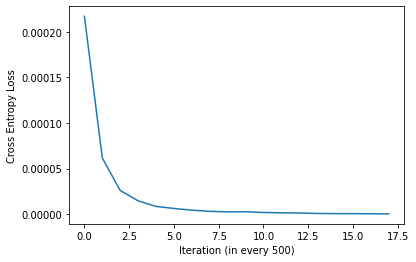

In [76]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [77]:
def new_prediction(plot):
  plot = custom_count_vectorizer.get_tensor(text)
  plot = plot.view(-1, input_dim).to(device)
  outputs = model(plot)
  _, predicted = torch.max(outputs, 1)
  return int(predicted)
  
def new_prediction_by_vector(vector):
  plot = vector
  plot = plot.view(-1, input_dim).to(device)
  outputs = model(plot)
  _, predicted = torch.max(outputs, 1)
  return int(predicted)

In [78]:
plot = "John McBut when a bomb goes off in the Bonwit Teller Department Store the police go insane trying to figure out what's going on. Soon, a man named Simon calls and asks for McClane. Simon tells Inspector Walter Cobb that McClane is going to play a game called \"Simon Says\". He says that McClane is going to do the tasks he assigns him. If not, he'll set off another bomb. With the help of a Harlem electrician, John McClane must race all over New York trying to figure out the frustrating puzzles that the crafty terrorist gives him. But when a bomb goes off in a subway station right by the Federal Reserve things start to get heated."
prediction=new_prediction(plot)
print(prediction,int_to_label[prediction])

1 action


In [79]:
out_true = []
out_pred = []
for plot in test_dataset:
  pred = new_prediction_by_vector(plot[0])
  out_true.append(plot[1])
  out_pred.append(pred)

cm = confusion_matrix(out_true, out_pred)
print(cm)
cr = classification_report(out_true, out_pred)
print(cr)

[[ 11   8  12   4   0   5   0   0   0   0   0   0   0   1   0   0   0]
 [ 10  87  13   3   1  19  14   0   0   0   0   2   0   3   1   0   0]
 [  7  10 175   1   3  46   6   0   0   0   0   3   0   1   0   0   0]
 [  8   8  22   1   0  10   0   0   1   0   0   0   0   1   0   0   0]
 [  0   1  10   1   6  16   2   0   1   0   0   1   0   0   0   0   0]
 [  2  13  64   1   5  91   5   0   0   0   0   0   0   2   0   0   0]
 [  0  13  19   0   0  18  15   0   0   0   0   0   1   2   0   0   0]
 [  0   2   0   0   0   1   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   2   0   0   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   1   4   0   0   3   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3   6   7   0   6  13   0   0   0   0   0  17   0   0   0   0   0]
 [  1   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   7  11   0   0   6   3   0   0   0   0   0   0   2   0   0   0]
 [  0 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Binary Count + Logistic Regression**

In [80]:
custom_count_vectorizer = Custom_Count_Vectorizer(corpus=corpus, corpus_label=corpus_label, vectorizer='COUNT-B')
dataset = custom_count_vectorizer.get_dataset(shuffle=True)

Using Binary Count Vectorizer


In [81]:
train_cnt = int(80.0 * len(dataset) / 100.0)
train_dataset = dataset[ : train_cnt]
test_dataset = dataset[train_cnt : ]
print('Train size =', len(train_dataset), '\nTest size =', len(test_dataset))

Train size = 3564 
Test size = 892


In [82]:
# Hyperparameters
batch_size = 220
num_iters = 6000
input_dim = len(dataset[0][0])
output_dim = len(all_genres)
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [83]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  
print(num_epochs)

370


In [84]:
class LogisticRegressionModel(nn.Module):
  def __init__(self, input_size, num_classes):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, x):
    logits  = self.linear(x)
    probas = F.softmax(logits, dim=1)
    return logits, probas

In [85]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=25769, out_features=19, bias=True)
)

In [86]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [87]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
  for i, (plots, labels) in enumerate(train_loader):

    plots = plots.view(-1, input_dim).to(device)
    labels = labels.to(device)

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    # Forward pass to get output/logits
    logits, probas = model(plots) 

    # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
    loss = F.cross_entropy(logits, labels)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

    iter += 1

    if iter % 1000 == 0:
      # Calculate Accuracy         
      correct = 0
      total = 0
      # Iterate through test dataset
      for plots, labels in test_loader:
               
        plots = plots.view(-1, input_dim).to(device)

        # Forward pass only to get logits/output
        logits, probas = model(plots)

        # Get predictions from the maximum value
        _, predicted = torch.max(probas, 1)

        # Total number of labels
        total += labels.size(0)


        # Total correct predictions
        if torch.cuda.is_available():
          correct += (predicted.cpu() == labels.cpu()).sum() 
        else:
          correct += (predicted == labels).sum()

      accuracy = 100 * correct.item() / total

      # Print Loss
      iteration_loss.append(loss.item())
      print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print("done training")

Iteration: 1000. Loss: 0.786159098148346. Accuracy: 46.0762331838565
Iteration: 2000. Loss: 0.48318541049957275. Accuracy: 47.6457399103139
Iteration: 3000. Loss: 0.2709837555885315. Accuracy: 47.98206278026906
Iteration: 4000. Loss: 0.1454479843378067. Accuracy: 47.6457399103139
Iteration: 5000. Loss: 0.11276122182607651. Accuracy: 47.869955156950674
Iteration: 6000. Loss: 0.07562022656202316. Accuracy: 47.53363228699551
done training


In [88]:
#settings 
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), project_path + 'binary_count_logistic_final.pkl') 

[0.786159098148346, 0.48318541049957275, 0.2709837555885315, 0.1454479843378067, 0.11276122182607651, 0.07562022656202316]


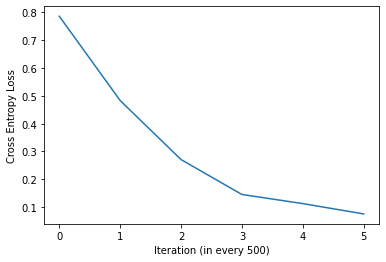

In [89]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [90]:
def new_prediction_lg(plot):
  plot = custom_count_vectorizer.get_tensor(text)
  plots = plot.view(-1, input_dim).to(device)
  logits, probas = model(plots)
  _, predicted = torch.max(probas, 1)
  return int(predicted)
  
def new_prediction_by_vector_lg(vector):
  plot = vector
  plot = plot.view(-1, input_dim).to(device)
  logits, probas = model(plot)
  _, predicted = torch.max(probas, 1)
  return int(predicted)

In [91]:
plot = "John McBut when a bomb goes off in the Bonwit Teller Department Store the police go insane trying to figure out what's going on. Soon, a man named Simon calls and asks for McClane. Simon tells Inspector Walter Cobb that McClane is going to play a game called \"Simon Says\". He says that McClane is going to do the tasks he assigns him. If not, he'll set off another bomb. With the help of a Harlem electrician, John McClane must race all over New York trying to figure out the frustrating puzzles that the crafty terrorist gives him. But when a bomb goes off in a subway station right by the Federal Reserve things start to get heated."
prediction=new_prediction_lg(plot)
print(prediction,int_to_label[prediction])

6 crime


In [92]:
out_true = []
out_pred = []
for plot in test_dataset:
  pred = new_prediction_by_vector_lg(plot[0])
  out_true.append(plot[1])
  out_pred.append(pred)

cm = confusion_matrix(out_true, out_pred)
print(cm)
cr = classification_report(out_true, out_pred)
print(cr)

[[  9  15  20   2   0  10   0   0   0   0   0   0   0   0   0   0]
 [  1  97  27   2   1  12   8   0   0   0   0   0   0   0   0   0]
 [  0   8 210   0   0  51   2   0   0   0   0   3   0   0   0   0]
 [  1  10  24   2   1   8   1   0   0   0   0   0   0   0   0   0]
 [  0   1  11   0   2  18   1   0   0   0   0   0   0   0   0   0]
 [  0  14  75   0   0  73   3   0   0   0   0   1   0   0   0   0]
 [  0  18  23   0   0  21  12   0   0   0   0   0   0   0   0   0]
 [  0   3   4   0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   4   0   0   2   0   0   0   0   0   0   0   0   0   0]
 [  1   3   2   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   4  20   0   0   7   1   0   0   0   0  12   0   0   0   0]
 [  0   1   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  1   2   4   0   0   7   1   0   0   0   0   0   0   7   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0   0   0 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Count + Deep Neural Network**

In [93]:
custom_count_vectorizer = Custom_Count_Vectorizer(corpus=corpus, corpus_label=corpus_label, vectorizer='COUNT')
dataset = custom_count_vectorizer.get_dataset(shuffle = True)

Using Count Vectorizer


In [94]:
train_cnt = int(80.0 * len(dataset) / 100.0)
train_dataset = dataset[ : train_cnt]
test_dataset = dataset[train_cnt : ]
print('Train size =', len(train_dataset), '\nTest size =', len(test_dataset))

Train size = 3564 
Test size = 892


In [95]:
# Hyperparameters
batch_size = 200
num_iters = 9000
input_dim = len(dataset[0][0])
output_dim = len(all_genres)
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [96]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  
print(num_epochs)

505


In [97]:
class DeepNeuralNetworkModel(nn.Module):
  def __init__(self, input_size, num_classes, num_hidden_1, num_hidden_2, num_hidden_3):
    super().__init__()
    ### 1st hidden layer: 784 --> 100
    self.linear_1 = nn.Linear(input_size, num_hidden_1)
    ### Non-linearity in 1st hidden layer
    self.relu_1 = nn.ReLU6()

    ### 2nd hidden layer: 100 --> 100
    self.linear_2 = nn.Linear(num_hidden_1, num_hidden_2)
    ### Non-linearity in 2nd hidden layer
    self.relu_2 = nn.ReLU6()

    self.linear_3 = nn.Linear(num_hidden_2, num_hidden_3)
    ### Non-linearity in 2nd hidden layer
    self.relu_3 = nn.ReLU6()

    ### Output layer: 100 --> 10
    self.linear_out = nn.Linear(num_hidden_3, num_classes)

  def forward(self, x):
    ### 1st hidden layer
    out  = self.linear_1(x)
    ### Non-linearity in 1st hidden layer
    out = self.relu_1(out)
    
    ### 2nd hidden layer
    out  = self.linear_2(out)
    ### Non-linearity in 2nd hidden layer
    out = self.relu_2(out)
    
    ### 2nd hidden layer
    out  = self.linear_3(out)
    ### Non-linearity in 2nd hidden layer
    out = self.relu_3(out)

    # Linear layer (output)
    probas  = self.linear_out(out)
    return probas

In [98]:
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden_1 = 550, num_hidden_2 = 256, num_hidden_3 = 64)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=25769, out_features=550, bias=True)
  (relu_1): ReLU6()
  (linear_2): Linear(in_features=550, out_features=256, bias=True)
  (relu_2): ReLU6()
  (linear_3): Linear(in_features=256, out_features=64, bias=True)
  (relu_3): ReLU6()
  (linear_out): Linear(in_features=64, out_features=19, bias=True)
)

In [99]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [100]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
  for i, (plots, labels) in enumerate(train_loader):

    plots = plots.view(-1, input_dim).to(device)
    labels = labels.to(device)

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    # Forward pass to get output/logits
    outputs = model(plots) 
    
    # Calculate Loss: softmax --> cross entropy loss
    loss = criterion(outputs, labels)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

    iter += 1

    if iter % 500 == 0:
      # Calculate Accuracy         
      correct = 0
      total = 0
      # Iterate through test dataset
      for plots, labels in test_loader:
               
        plots = plots.view(-1, input_dim).to(device)

        # Forward pass only to get logits/output
        outputs = model(plots)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs, 1)

        # Total number of labels
        total += labels.size(0)


        # Total correct predictions
        if torch.cuda.is_available():
          correct += (predicted.cpu() == labels.cpu()).sum() 
          #print('cuda', predicted)
        else:
          correct += (predicted == labels).sum()
          #print('normal', predicted)

      accuracy = 100 * correct.item() / total
      # Print Loss
      iteration_loss.append(loss.item())
      print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.00048243903438560665. Accuracy: 44.61883408071749
Iteration: 1000. Loss: 0.00013127323472872376. Accuracy: 44.61883408071749
Iteration: 1500. Loss: 5.484817666001618e-05. Accuracy: 44.61883408071749
Iteration: 2000. Loss: 3.11278818116989e-05. Accuracy: 45.2914798206278
Iteration: 2500. Loss: 1.850101580203045e-05. Accuracy: 45.85201793721973
Iteration: 3000. Loss: 1.386897565680556e-05. Accuracy: 45.964125560538115
Iteration: 3500. Loss: 8.921516382542904e-06. Accuracy: 45.964125560538115
Iteration: 4000. Loss: 6.909251624165336e-06. Accuracy: 45.73991031390135
Iteration: 4500. Loss: 4.712352165370248e-06. Accuracy: 45.62780269058296
Iteration: 5000. Loss: 3.140562967018923e-06. Accuracy: 45.51569506726457
Iteration: 5500. Loss: 3.067240413656691e-06. Accuracy: 45.2914798206278
Iteration: 6000. Loss: 1.9299939140182687e-06. Accuracy: 45.51569506726457
Iteration: 6500. Loss: 1.6754817124819965e-06. Accuracy: 45.51569506726457
Iteration: 7000. Loss: 1.49964830598

In [101]:
#settings 
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), project_path + 'Count_DEEP_NN_model_final.pkl') 

[0.00048243903438560665, 0.00013127323472872376, 5.484817666001618e-05, 3.11278818116989e-05, 1.850101580203045e-05, 1.386897565680556e-05, 8.921516382542904e-06, 6.909251624165336e-06, 4.712352165370248e-06, 3.140562967018923e-06, 3.067240413656691e-06, 1.9299939140182687e-06, 1.6754817124819965e-06, 1.4996483059803722e-06, 1.2576523431562237e-06, 8.928763577387144e-07, 5.781641903013224e-07, 6.927207891749276e-07]


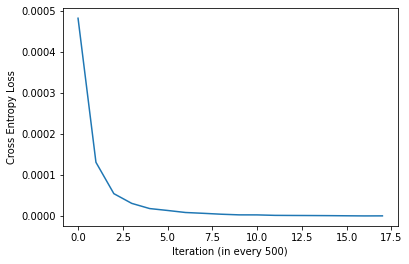

In [102]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [103]:
def new_prediction(plot):
  plot = custom_count_vectorizer.get_tensor(text)
  plot = plot.view(-1, input_dim).to(device)
  outputs = model(plot)
  _, predicted = torch.max(outputs, 1)
  return int(predicted)
  
def new_prediction_by_vector(vector):
  plot = vector
  plot = plot.view(-1, input_dim).to(device)
  outputs = model(plot)
  _, predicted = torch.max(outputs, 1)
  return int(predicted)

In [104]:
plot = "John McBut when a bomb goes off in the Bonwit Teller Department Store the police go insane trying to figure out what's going on. Soon, a man named Simon calls and asks for McClane. Simon tells Inspector Walter Cobb that McClane is going to play a game called \"Simon Says\". He says that McClane is going to do the tasks he assigns him. If not, he'll set off another bomb. With the help of a Harlem electrician, John McClane must race all over New York trying to figure out the frustrating puzzles that the crafty terrorist gives him. But when a bomb goes off in a subway station right by the Federal Reserve things start to get heated."
prediction=new_prediction(plot)
print(prediction,int_to_label[prediction])

1 action


In [105]:
out_true = []
out_pred = []
for plot in test_dataset:
  pred = new_prediction_by_vector(plot[0])
  out_true.append(plot[1])
  out_pred.append(pred)

cm = confusion_matrix(out_true, out_pred)
print(cm)
cr = classification_report(out_true, out_pred)
print(cr)

[[ 14  11  11   4   0  11   0   0   0   0   0   1   0   0   0   0   0   0]
 [  7  95  27   1   0  10   9   0   0   0   0   2   0   0   0   0   0   0]
 [  4  24 194   3   0  41   4   0   0   0   0   4   0   2   0   0   0   0]
 [  5   9  17   4   0  15   0   0   1   0   0   0   0   1   0   0   0   0]
 [  1   7  19   1   4  14   2   0   0   0   0   1   0   0   0   0   0   0]
 [  1  19  77   1   1  64   5   0   0   1   0   0   0   3   0   0   0   0]
 [  0  10  23   0   0  12  12   0   0   0   0   0   0   0   0   0   0   0]
 [  0   2   1   0   0   1   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0   1   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   3   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   2  14   0   0   5   0   0   0   0   0  16   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   7   7   0   0   6

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


** Count + Logistic Regression **

In [106]:
custom_count_vectorizer = Custom_Count_Vectorizer(corpus=corpus, corpus_label=corpus_label, vectorizer='COUNT')
dataset = custom_count_vectorizer.get_dataset(shuffle=True)

Using Count Vectorizer


In [107]:
train_cnt = int(80.0 * len(dataset) / 100.0)
train_dataset = dataset[ : train_cnt]
test_dataset = dataset[train_cnt : ]
print('Train size =', len(train_dataset), '\nTest size =', len(test_dataset))

Train size = 3564 
Test size = 892


In [108]:
# Hyperparameters
batch_size = 200
num_iters = 9000
input_dim = len(dataset[0][0])
output_dim = len(all_genres)
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [109]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  
print(num_epochs)

505


In [110]:
class LogisticRegressionModel(nn.Module):
  def __init__(self, input_size, num_classes):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, x):
    logits  = self.linear(x)
    probas = F.softmax(logits, dim=1)
    return logits, probas

In [111]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=25769, out_features=19, bias=True)
)

In [112]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [113]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
  for i, (plots, labels) in enumerate(train_loader):

    plots = plots.view(-1, input_dim).to(device)
    labels = labels.to(device)

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    # Forward pass to get output/logits
    logits, probas = model(plots) 

    # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
    loss = F.cross_entropy(logits, labels)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

    iter += 1

    if iter % 1000 == 0:
      # Calculate Accuracy         
      correct = 0
      total = 0
      # Iterate through test dataset
      for plots, labels in test_loader:
               
        plots = plots.view(-1, input_dim).to(device)

        # Forward pass only to get logits/output
        logits, probas = model(plots)

        # Get predictions from the maximum value
        _, predicted = torch.max(probas, 1)

        # Total number of labels
        total += labels.size(0)


        # Total correct predictions
        if torch.cuda.is_available():
          correct += (predicted.cpu() == labels.cpu()).sum() 
        else:
          correct += (predicted == labels).sum()

      accuracy = 100 * correct.item() / total

      # Print Loss
      iteration_loss.append(loss.item())
      print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print("done training")

Iteration: 1000. Loss: 0.1719920039176941. Accuracy: 48.99103139013453
Iteration: 2000. Loss: 0.048652954399585724. Accuracy: 48.99103139013453
Iteration: 3000. Loss: 0.024653522297739983. Accuracy: 48.20627802690583
Iteration: 4000. Loss: 0.01086440309882164. Accuracy: 47.75784753363229
Iteration: 5000. Loss: 0.0064383638091385365. Accuracy: 47.53363228699551
Iteration: 6000. Loss: 0.0033879175316542387. Accuracy: 47.08520179372197
Iteration: 7000. Loss: 0.002337775193154812. Accuracy: 46.860986547085204
Iteration: 8000. Loss: 0.0013752158265560865. Accuracy: 46.74887892376682
Iteration: 9000. Loss: 0.0009972031693905592. Accuracy: 46.74887892376682
done training


In [114]:
#settings 
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), project_path + 'Count_logistic_regression_final.pkl') 

[0.1719920039176941, 0.048652954399585724, 0.024653522297739983, 0.01086440309882164, 0.0064383638091385365, 0.0033879175316542387, 0.002337775193154812, 0.0013752158265560865, 0.0009972031693905592]


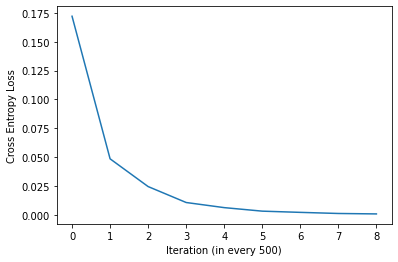

In [115]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [116]:
def new_prediction_lg(plot):
  plot = custom_count_vectorizer.get_tensor(text)
  plots = plot.view(-1, input_dim).to(device)
  logits, probas = model(plots)
  _, predicted = torch.max(probas, 1)
  return int(predicted)
  
def new_prediction_by_vector_lg(vector):
  plot = vector
  plot = plot.view(-1, input_dim).to(device)
  logits, probas = model(plot)
  _, predicted = torch.max(probas, 1)
  return int(predicted)

In [117]:
plot = "John McBut when a bomb goes off in the Bonwit Teller Department Store the police go insane trying to figure out what's going on. Soon, a man named Simon calls and asks for McClane. Simon tells Inspector Walter Cobb that McClane is going to play a game called \"Simon Says\". He says that McClane is going to do the tasks he assigns him. If not, he'll set off another bomb. With the help of a Harlem electrician, John McClane must race all over New York trying to figure out the frustrating puzzles that the crafty terrorist gives him. But when a bomb goes off in a subway station right by the Federal Reserve things start to get heated."
prediction=new_prediction_lg(plot)
print(prediction,int_to_label[prediction])

1 action


In [118]:
out_true = []
out_pred = []
for plot in test_dataset:
  pred = new_prediction_by_vector_lg(plot[0])
  out_true.append(plot[1])
  out_pred.append(pred)

cm = confusion_matrix(out_true, out_pred)
print(cm)
cr = classification_report(out_true, out_pred)
print(cr)

[[  8  14  19   5   0   8   0   0   0   0   0   0   0   0   0]
 [  5 101  24   4   1  19   7   0   0   0   0   2   0   0   0]
 [  1  11 182   3   1  48   3   0   0   0   0   3   0   0   0]
 [  3  16  18   1   4  10   1   0   0   0   0   1   0   0   0]
 [  0   2  11   0   6  19   5   0   0   0   0   2   0   0   0]
 [  1  11  62   0   2  69   7   0   0   0   0   2   3   0   0]
 [  0  19  20   0   0  18  17   0   0   0   0   0   0   0   0]
 [  0   2   1   0   0   1   1   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   1   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   1   0   0   0   0   0   0   0   0]
 [  0   1  16   0   0   5   0   0   0   0   0  27   0   0   0]
 [  0   6   8   0   0  10   1   0   0   0   0   0   5   0   0]
 [  0   0   2   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0   0]]
              precision    recall  f1-score   support


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
